In [1]:
import torch 
import torch.nn as nn
from  torchvision import  transforms,datasets
from torch.utils.data  import Dataset,DataLoader,random_split
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
    ]) 

In [3]:
dataset = datasets.MNIST(root='./data/MNIST',train=True,transform=transform,download=True)

In [4]:
train_size =int(len(dataset)*0.7)
test_size =int(len(dataset)-train_size)
train_dataset,test_dataset=random_split(dataset,[train_size,test_size])
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [5]:
class simpleCNN(nn.Module):
    def __init__(self,class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 输入通道1，输出通道32，3x3卷积核，步长1，padding 1
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 最大池化

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 输入通道32，输出通道64
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 全连接层，输入 64*7*7，输出 128
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, class_num)  # 全连接层，输入 128，输出 10 (类别数)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(out.size(0), -1)  # 展平操作
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

In [6]:
model =simpleCNN(10)
loss_func = nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(model.parameters(),lr =1e-4)

In [7]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        for idx,(img,label)  in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc=f"Epoch {epoch+1}/{epochs}"):
            
            out=model(img)
            loss=loss_func(out,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss+=loss.item()
        print(f"")
        with torch.no_grad():
            model.eval()
            correct=0 
            total=0
            total += label.size(0)
            for idx,(img,label)  in tqdm(enumerate(test_dataloader),total=len(test_dataloader),desc=f"Testing"):
                out =model(img)
                _,pred =torch.max(out,1)
                total += label.size(0)
                correct += (pred == label).sum().item()
                val_acc = 100 * correct / total
        print(f"{epoch+1}/{epochs}: loss: {loss.item()}  acc:{val_acc:.2f}")
        

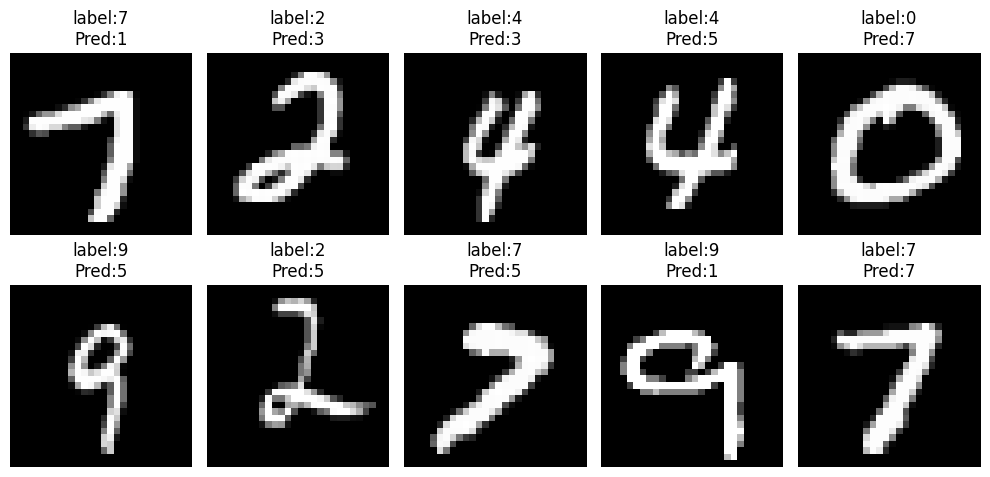

In [ ]:

import matplotlib.pyplot  as plot
import numpy as np
num_rows = 2
num_cols = 5
fig, axes = plot.subplots(num_rows, num_cols, figsize=(10, 5)) 
with torch.no_grad(): 
    model.eval()  
    for i, (images, labels) in enumerate(test_dataloader):
        if i >10:
            break
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(min(10, len(images))):
            ax = axes[i // num_cols, i % num_cols]

            img = np.transpose(images[i], (1, 2, 0))
            ax.imshow(img, cmap='gray')  
            ax.set_title(f"label:{labels[i]}\nPred:{predicted[i]}")
            ax.axis('off')  
plot.tight_layout() 
plot.show()  